# Jedi vs. Sith
A binary image classifier example

## Goal

The goal of this notebook is to demonstrate the functionality of a binary image classifier network.

## Architecture

This neural network will use a Convolutional architecture on the Keras neural network framework with TensorFlow as the backend. After training, it will classify images as either 'Jedi' or 'Sith'.

In [1]:
# Set up TensorFlow
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-11-28 15:15:06.565185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 15:15:06.570807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 15:15:06.570939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import random

## Global Parameters

The global parameters are batch size (32) and image size (200x200).

In [3]:
batch_size = 32
img_height = 200
img_width = 200

## Training Dataset

We have a training dataset of hand-curated images, all sized to 200x200px in two subdirectories called "jedi" and "sith". We'll load them here.

In [4]:
data_dir = pathlib.Path('training_set_binary')

jedi = list(data_dir.glob('jedi/*'))
sith = list(data_dir.glob('sith/*'))
num_jedi = len(jedi)
num_sith = len(sith)

print(num_jedi, 'Jedi images and', num_sith, 'Sith images')

707 Jedi images and 584 Sith images


A Jedi looks like this:


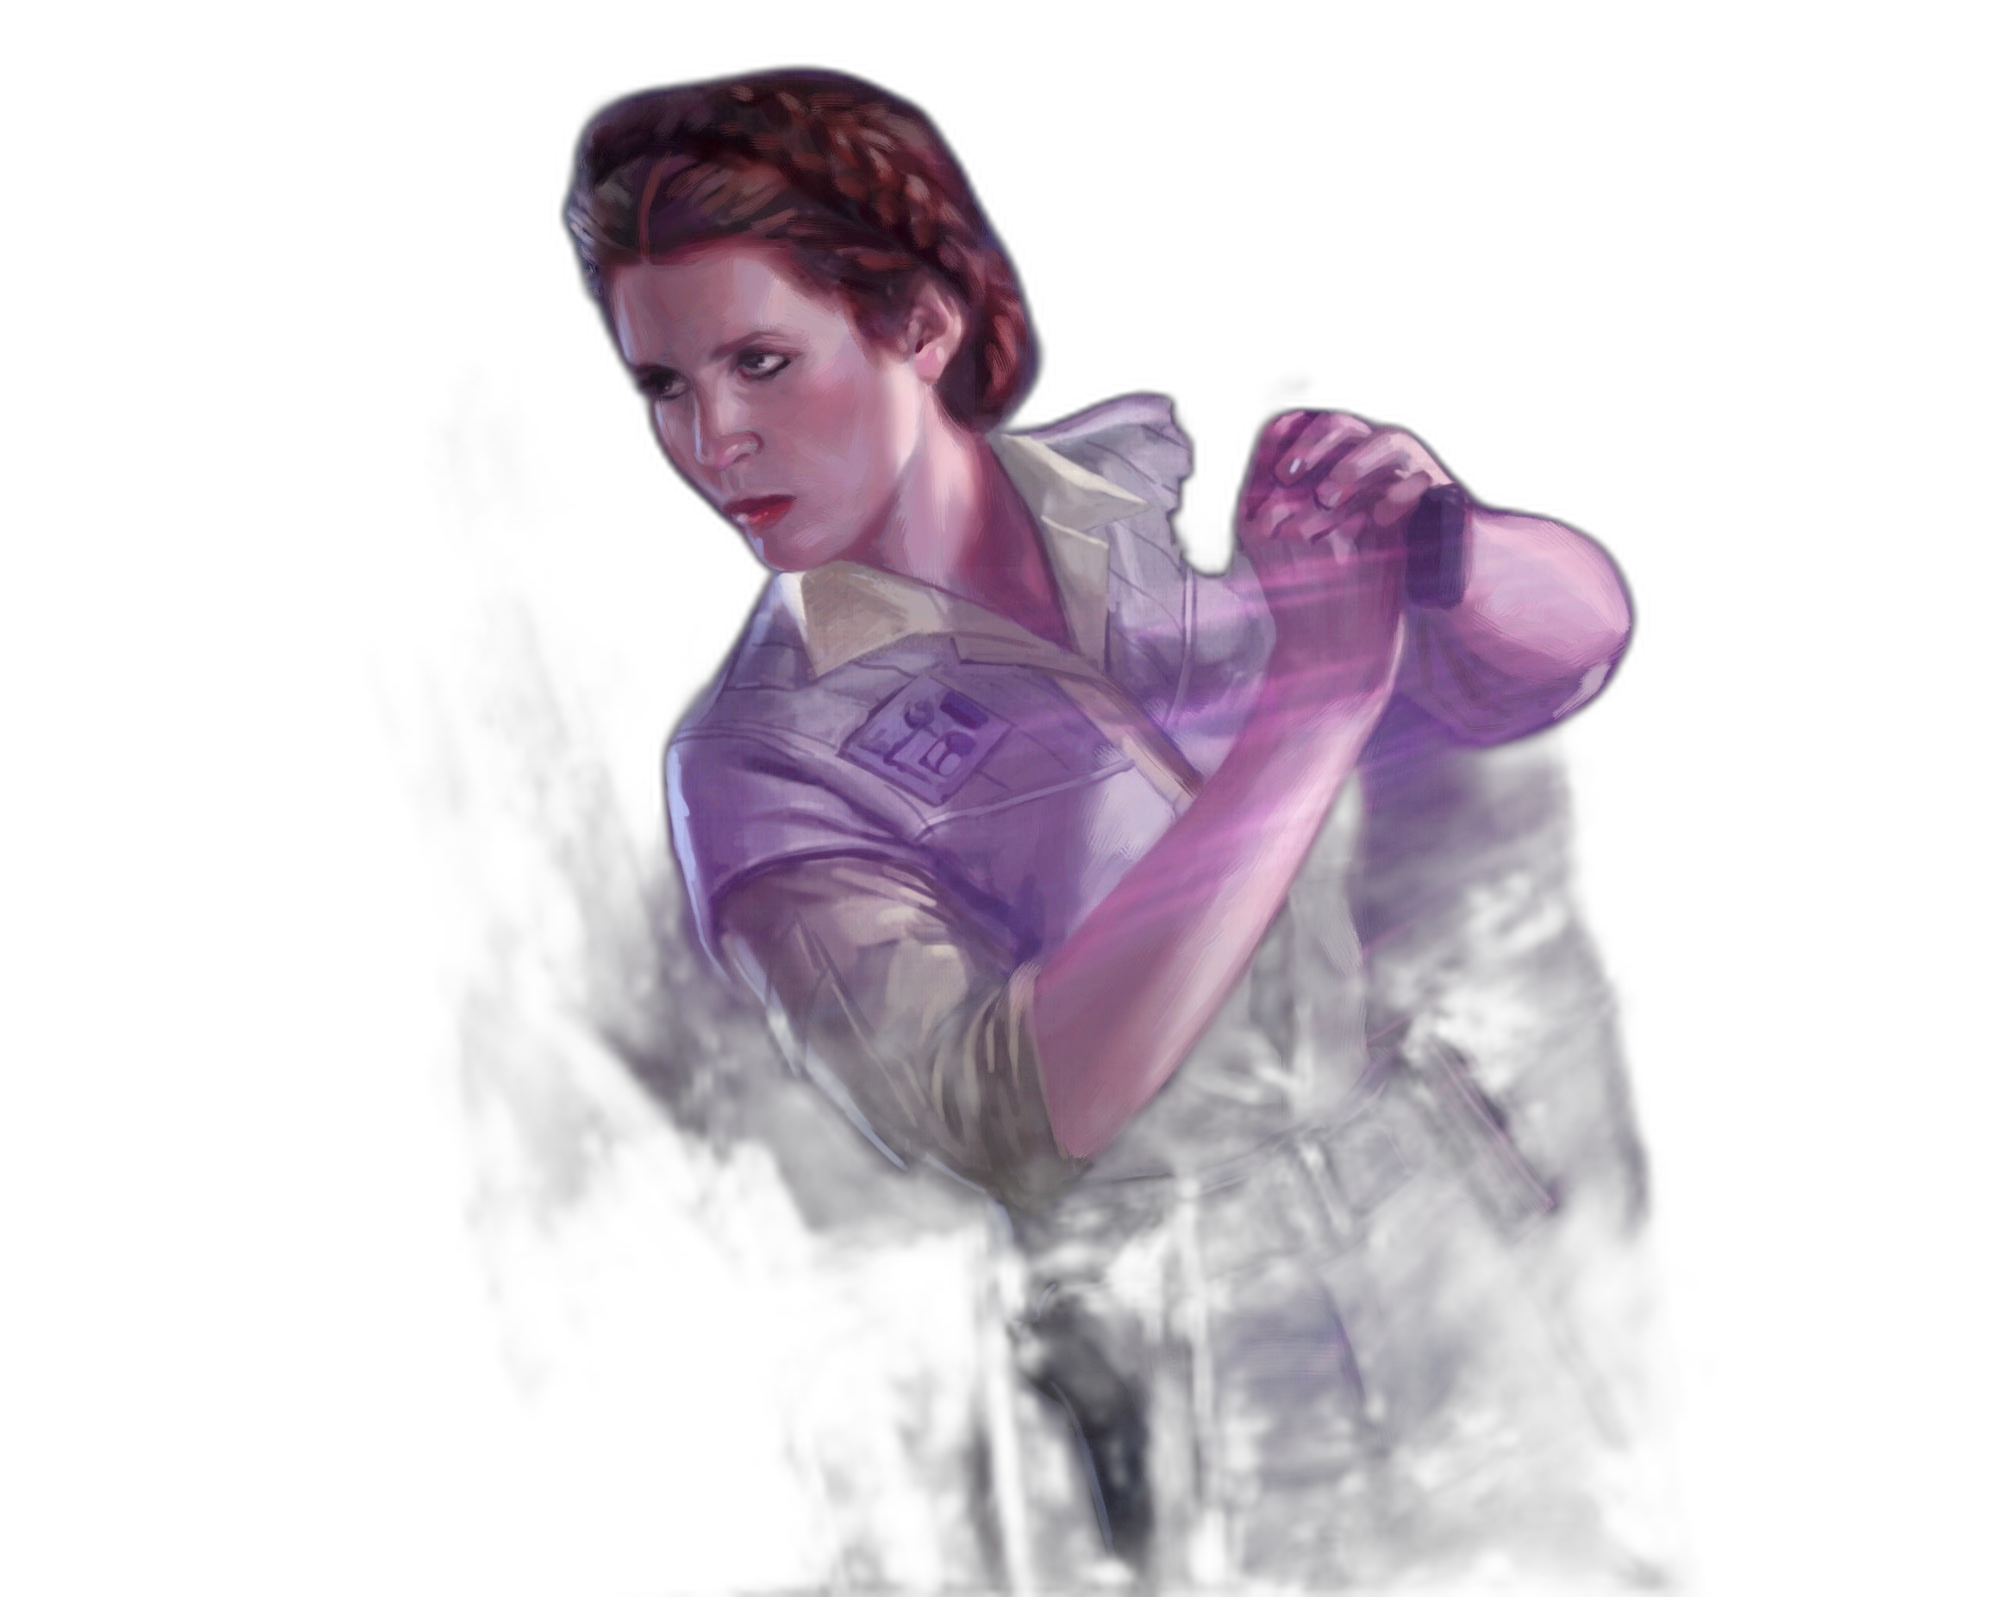

In [5]:
print('A Jedi looks like this:')
PIL.Image.open(jedi[random.randint(0,num_jedi)])

A Sith looks like this:


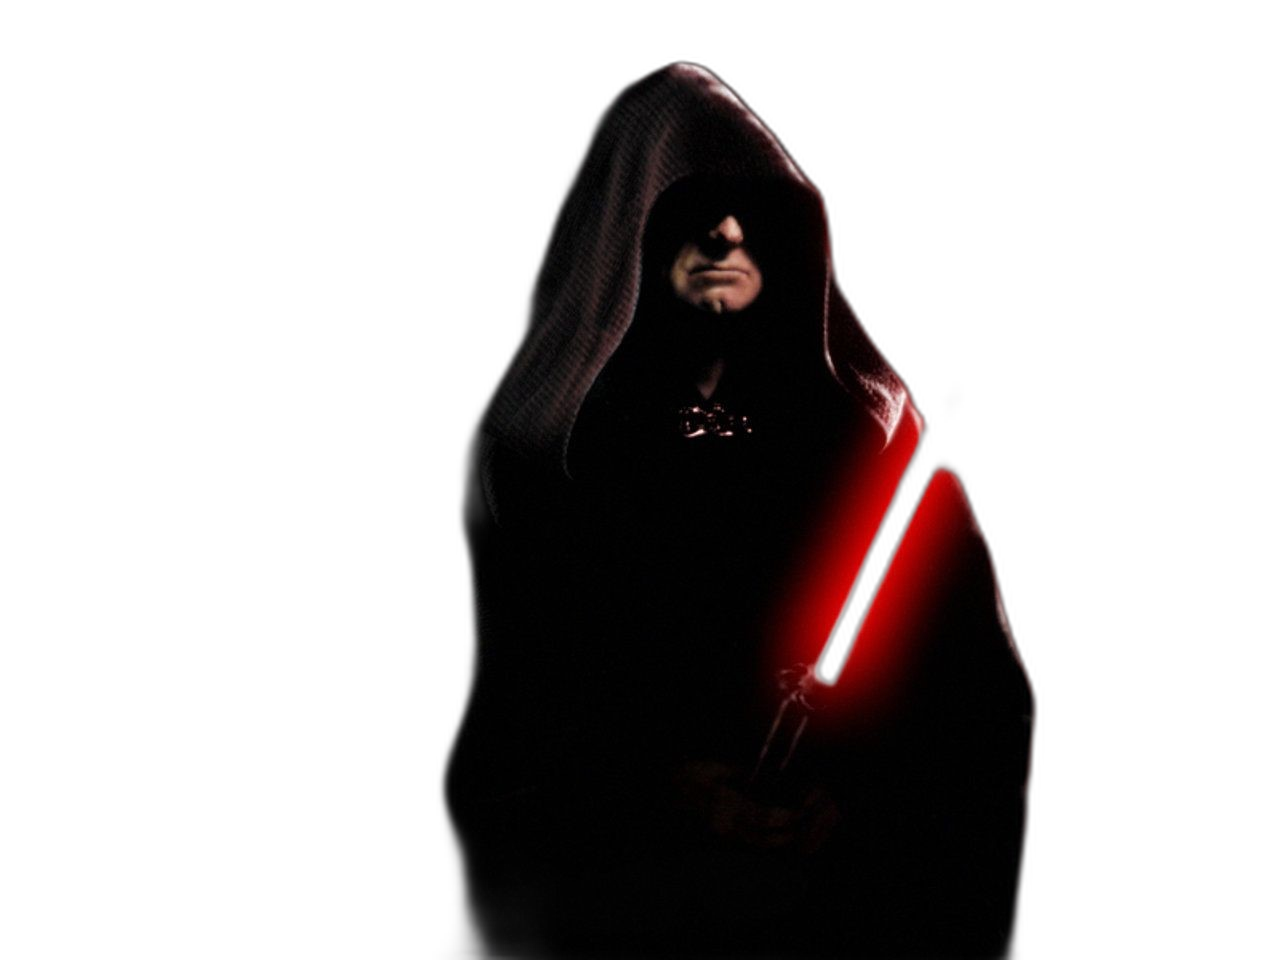

In [6]:
print('A Sith looks like this:')
PIL.Image.open(sith[random.randint(0,num_sith)])

In [7]:
# Create a dataset from the input images, using 80% for training and 20% for validation
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

class_names = train_ds.class_names

Found 1291 files belonging to 2 classes.
Using 1033 files for training.


2022-11-28 15:15:07.400558: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 15:15:07.400796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 15:15:07.401201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 15:15:07.401306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [8]:
# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 1291 files belonging to 2 classes.
Using 258 files for validation.


## I/O Tuning

We'll use the AUTOTUNE feature of `tf.data` to tune the I/O performance parameters.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model

The network model is a sequence of layers of convolutions alternating with max pooling functions. Each convolution layer produces a feature map as an output. The max pooling layers reduce the size of each feature map to maximize the magnitude of the observed features. The final layers are "fully-connected" layers, meaning they form a proper deep neural net.

Conceptually, we can think of it as a two-layer model: Convolutions to produce feature maps, which are exaggerated impressions of prominent features of the image, and a neural net that looks at the features and finds patterns in them.

In [10]:
model = tf.keras.Sequential()

### Layer 0: Data Augmentation

Since we have so few training images to work with, we will use some data augmentation techniques built into TensorFlow to pad out our learning dataset.

The first layer is an input layer. Since our images are 200x200px color images, we need an input tensor shape of 200x200x3. This layer will randomly flip the image horizontally, vertically, both, or none.

The second layer will randomly rotate the image left or right by up to 20%.

The third layer will randomly adjust the contrast by 20%.

The fourth layer will randomly zoom into a part of the image by 20-30%.

In [11]:
model.add(tf.keras.layers.RandomFlip("horizontal_and_vertical",
                                 input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.RandomRotation(0.2))
model.add(tf.keras.layers.RandomContrast(0.2))
model.add(tf.keras.layers.RandomZoom(height_factor=(-0.3, -0.2)))

### Layer 0.5 Data Normalization

Neurons operate best on values between 0 and 1. Let's remap the color values to that domain from their current range of 0-255.

In [12]:
model.add(tf.keras.layers.Rescaling(1./255))

### Layer 1: Input Convolution

We'll use a ReLU activation function so we deliberately fail to backpropagate any negative bias, which saves us a bit of computational overhead. We'll use 16 filters to start with and a 3x3 kernel, which are good values to use unless you have good reason to use other ones (see many, many papers on why 3x3 is the optimal kernel size for pretty much any CNN).

In [13]:
model.add(tf.keras.layers.Conv2D(16,
                                 (3,3),
                                 activation='relu'))

### Layer 2: Dropout

To reduce overfitting, we will randomly knock out 1/5 of the neurons in the network.

In [14]:
model.add(tf.keras.layers.Dropout(rate=0.2))

### Layer 3: Max Pooling

Takes the output of the previous layer (a feature map) and pools each quadrant, taking the maximum value thereof.

In [15]:
model.add(tf.keras.layers.MaxPooling2D(2, 2))

### Layer 4: Second Convolution

Convolves the maximized pooled feature map from Layer 1, using 32 filters this time, and still using a ReLU activation function to eliminate negative values.

In [16]:
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))

### Layer 5: Max Pooling

Another max pooling layer to separate the convolutions like thin paper sheets separate deli slices.

In [17]:
model.add(tf.keras.layers.MaxPooling2D(2, 2))

### Layer 6: Third Convolution

This time, we're bumping the filters up to 64, because want to learn more from less input data.

In [18]:
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))

### Layer 7: Max Pooling

You guessed it, another max pooling layer

In [19]:
model.add(tf.keras.layers.MaxPooling2D(2, 2))

### Layer 8: Fourth Convolution

Same as the third.

In [20]:
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))

### Layer 9: Max Pooling

Lather, rinse, repeat.

In [21]:
model.add(tf.keras.layers.MaxPooling2D(2, 2))

### Layer 10: Fifth Convolution

Same as the third and fourth.

In [22]:
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))

### Layer 11: Max Pooling

Last one.

In [23]:
model.add(tf.keras.layers.MaxPooling2D(2, 2))

### Layer 12: Flattening

The output shape of the last max pooling layer is 4x4x64. Since we want to learn from our feature map by using a Dense Neural Net layer, we need to flatten our 3 dimensional tensor into a 1-dimensional vector. 4 times 4 is 16 and 16 times 64 is 1024. Therefore, the input to our DNN will be a vector containing 1024 terms.

In [24]:
model.add(tf.keras.layers.Flatten())

### Layer 13: Dropout

To reduce overfitting, we will randomly knock out 1/5 of the neurons in the network.

In [25]:
model.add(tf.keras.layers.Dropout(rate=0.2))

### Layer 14: Dense Neural Net

This is the layer that actually _makes inferences_ about the input data, recognizing connections between data points. We want to have one connection (because we have only two possible outcomes - a binary classifier) per pair of adjacent data points. ~~We will use 257 neurons, the mean of the input layer (512) and output layer (1).~~ We'll use 512 neurons. 257 gives decent performance overall but for some reason gets confused about people with dark skin. 512 neurons get less confused. We're again using ReLU as the activation function to prevent backpropagation of negative bias, which adds complexity to the computation.

In [26]:
model.add(tf.keras.layers.Dense(512, activation='relu'))

## Layer 15: Dropout

A final dropout layer that randomly knocks out 2/5 of the neurons in the network.

In [27]:
model.add(tf.keras.layers.Dropout(rate=0.4))

### Layer 16: Ouput DNN

Our final layer is a dense neural network consisting of a single neuron - we only want one answer. This layer takes the 512 answers from the previous layer and makes the final call, applying a sigmoid function to maximize the magnitude of our single yes or no option: Jedi or Sith.

(Fun fact: we really should be using a step function, but the discontinuity causes the derivative of the function to be zero, which would mean that the weight fails to update during backpropagation, so we use a sigmoid function instead, which accomplishes the same thing after rounding.)

In [28]:
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### Model Summary

16 layers this time (we added some dropouts and augmentation layers) and ready to rock!

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 200, 200, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 200, 200, 3)      0         
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, 200, 200, 3)      0         
 rast)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 200, 200, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 16)      4

## Detour into Feature Maps

We're going to create a second model that outputs the feature maps from each of the convolution layers when we ask it to predict.

In [30]:
conv_layer_idx = [5, 8, 10, 12, 14]
feature_outputs = [model.layers[i].output for i in conv_layer_idx]
feature_model = tf.keras.Model(inputs=model.inputs, outputs=feature_outputs)

## Training

Our model will be trained by minimizing a binary cross-entropy loss function. See [Understanding Binary Cross-Entropy Loss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) to better understand why. 

Binary cross-entropy loss function:
$$
H(p,q) = - \frac{1}{N} \sum_{i=1}^N{y_i} \cdot \log(p(y_i)) + (1 - y_i) \cdot \log(1 - p(y_i))
$$
where $y$ is the dependent variable ("Sith-ness"), $p(y)$ is the probability that the image shows a Sith, and $q$ is the *estimated* probability that the image shows a Sith. The formula relates the magnitude ($H$) of how far off the mark the guess ($q$) was from the real value ($p$).

We will be applying the Root Mean Square Propagation (RMSProp) optimizer function to adjust learning rate dynamically. [Read more about it here.](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) Our baseline learning rate will be 0.0001 to prevent model divergence.

Root mean squre error:
$$
\textrm{RMSE} = \sqrt{\frac{\sum_{i=1}^{N}(\hat{y}_i - y_i)^2}{N}}
$$

In [31]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
    metrics='accuracy')

### Train yourself to let go of everything you fear to lose.

~~We'll train for 6 epochs. 6-8 is a good range for this network. I started with 10, which overfit the model readily, even with dropouts.~~

Now that we have the values in the correct domain (\[0..1\]), I can train for longer without it overfitting, leading to better results. 

In [32]:
history = model.fit(
    train_ds,
    epochs=12,
    verbose=1,
    validation_data=val_ds,)

Epoch 1/12


2022-11-28 15:15:13.612908: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


33/33 [==============================] - 21s 393ms/step - loss: 0.6878 - accuracy: 0.5373 - val_loss: 0.6876 - val_accuracy: 0.5775
Epoch 2/12
33/33 [==============================] - 1s 24ms/step - loss: 0.6841 - accuracy: 0.5411 - val_loss: 0.6835 - val_accuracy: 0.5775
Epoch 3/12
33/33 [==============================] - 1s 24ms/step - loss: 0.6792 - accuracy: 0.5450 - val_loss: 0.6792 - val_accuracy: 0.5775
Epoch 4/12
33/33 [==============================] - 1s 25ms/step - loss: 0.6739 - accuracy: 0.5460 - val_loss: 0.6749 - val_accuracy: 0.5775
Epoch 5/12
33/33 [==============================] - 1s 28ms/step - loss: 0.6688 - accuracy: 0.5460 - val_loss: 0.6707 - val_accuracy: 0.5775
Epoch 6/12
33/33 [==============================] - 1s 25ms/step - loss: 0.6652 - accuracy: 0.5470 - val_loss: 0.6664 - val_accuracy: 0.5814
Epoch 7/12
33/33 [==============================] - 1s 24ms/step - loss: 0.6591 - accuracy: 0.5479 - val_loss: 0.6620 - val_accuracy: 0.5814
Epoch 8/12
33/33 [====

### Save trained model

In [33]:
model_version = 34
file_path = f"./models/jedi_sith/{model_version}/"
tf.saved_model.save(model, file_path)

2022-11-28 15:15:39.443816: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/jedi_sith/34/assets


## Jedi or Sith?

Now let's give it our own images and see if it thinks the image shows a Jedi or a Sith.

In [34]:
from rembg import remove
from rembg import session_factory
import ipywidgets as widgets
import io

uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

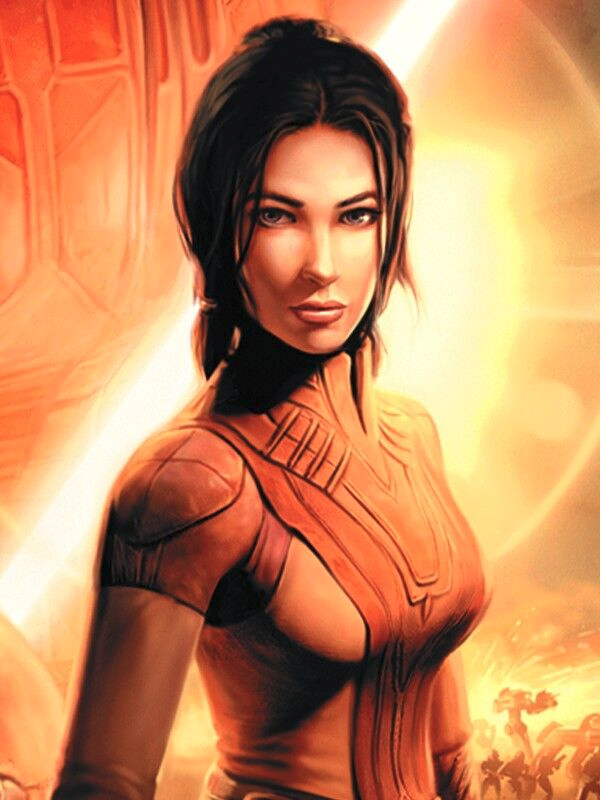

In [68]:
for name, file_info in uploader.value.items():
    our_image = PIL.Image.open(io.BytesIO(file_info['content']))
    
our_image

2022-11-28 15:18:27.138901931 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:540 CreateExecutionProviderInstance] Failed to create TensorrtExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html#requirements to ensure all dependencies are met.


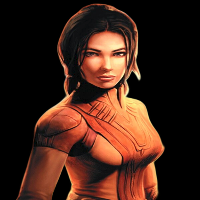

In [69]:
our_image = PIL.Image.open(io.BytesIO(file_info['content']))
our_image = remove(our_image, session=session_factory.new_session("u2net_human_seg")) # remove background
our_image = tf.keras.utils.img_to_array(our_image)
our_image = tf.image.resize(our_image, [img_height,img_width])
our_image_array = our_image[:,:,:3] # discard alpha channel
tf.keras.utils.array_to_img(our_image_array)

In [70]:
our_image_array = tf.expand_dims(our_image_array, 0) # Create a batch of a single image

In [71]:
our_predictions = model.predict(our_image_array)
our_score = our_predictions[0][0]
our_class = class_names[int(np.around(our_score))]

print(our_score)

print("This image most likely shows a {}".format(our_class))

0.3848804
This image most likely shows a jedi


### How did our model see this image?

We'll ask the second model (`feature_model`) to make a prediction here, which you recall, causes it to output the feature maps.

In [ ]:
from matplotlib import pyplot

feature_maps = feature_model.predict(our_image_array)
sizes = [16, 32, 64, 64, 64]
row_size = 8

for map_index, feature_map in enumerate(feature_maps):
    current_index = 1
    num_rows = int(sizes[map_index]/row_size)
    figure = pyplot.figure(figsize=(16,16))
    
    for row in range(num_rows):
        for column in range(row_size):
            ax = figure.add_subplot(num_rows, row_size, current_index)
            ax.set_xticks([])
            ax.set_yticks([])
            
            # use grayscale filter
            pyplot.imshow(feature_map[0, :, :, current_index-1])
            current_index += 1
            
    # show the plot
    pyplot.show()